# Speaker Recognition

This CDS project uses VCTK dataset which is conveinet to collect from tensorflow built-in packages and the objective of this model aims to correctly predict the speaker given audio files with various accents after training.

Note that the dataset is downloaded and collected from:

https://metatext.io/datasets/cstr-vctk-corpus


Section 1: Data Preprocessing and saved them to be CSV files and Pandas AND Data Preparation to extarct main features. 

Section 2: Data Split for training, testing, and validation set AND Data handling.

Section 3: Model Training

Section 4: Evalution Methodology

Section 5: Results Discussion

#### (Please refer to the report for more detailed information on each section)


### Import Necessary Libraries

In [1]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import numpy
import csv
import os
#import librosa
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# from keras import backend as K
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Flatten
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
# from keras.preprocessing.image import ImageDataGenerator
# from keras import models
# from keras import layers
# import keras

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import collections


### Section 1: Data Pre-processing and Feature Extraction

In [ ]:
CREATE_CSV_FILES = True

def extractWavFeatures(soundFilesFolder, csvFileName,n):
    header = 'speaker_ID audio_no chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header = header.split()
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for audiofile in os.listdir(f'{soundFilesFolder}'):
        try:
            number = f'{soundFilesFolder}/{audiofile}'
            y, sr = librosa.load(number, mono=True, duration=30)
            # remove leading and trailing silence
            y, index = librosa.effects.trim(y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{n} {audiofile[5:8]} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            writer.writerow(to_append.split())
        except:
            pass
    file.close()

start = 40
if (CREATE_CSV_FILES == True):
    ls_speaker = []
    ls_no = []
    n = start
    for filename in os.listdir('wav48')[start:start+10]:
        print(filename)
        extractWavFeatures("wav48/"+filename, "processed_data/data_" + filename + ".csv",n)
        ls_speaker.append(filename)
        ls_no.append(n)
        n+=1
    df = pd.DataFrame({'speaker' : ls_speaker, 'speaker_ID' : ls_no})
    df.to_csv("speaker_id.csv")
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

In [ ]:
if (CREATE_CSV_FILES == True):
    ls_speaker = []
    ls_no = []
    n = 0
    for filename in os.listdir('wav48'):
        ls_speaker.append(filename)
        ls_no.append(n)
        n+=1
    df = pd.DataFrame({'speaker' : ls_speaker, 'speaker_ID' : ls_no})
    df.to_csv("speaker_id.csv")

In [26]:
ls = []
n = 0
for filename in os.listdir('processed_data'):
    ls.append(pd.read_csv('processed_data/' + filename, index_col=None))
    n+=1
print(n)
data = pd.concat(ls, axis=0, ignore_index=True)
data.to_csv("processed_data.csv")
data

### Section 2:  (1) Data Split:
##### training 70%, testing 15%, validation 15%

In [2]:
data = pd.read_csv("processed_data.csv")
# Remove Unnamed columns in pandas dataframe 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.drop(['chroma_stft'], axis=1) # We are not including this in the features as 
data.head()

,speaker_ID,audio_no,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0,1,0.074879,2497.929082,2268.324461,4347.529516,0.143012,-307.451050,57.879471,11.893770,...,-7.967688,4.199481,1.773855,8.009322,6.938719,7.036314,3.976959,5.085256,-1.438815,-1.099089
1,0,2,0.066099,1892.849522,2102.600575,3327.249023,0.101247,-329.564026,66.828552,12.338695,...,-6.671147,7.486201,0.502710,9.984730,9.007502,5.632601,3.501462,0.573889,0.040695,-1.841341
2,0,3,0.082535,2222.535114,2077.810702,3791.664807,0.125326,-285.457520,66.315643,4.616204,...,-9.837260,4.760407,1.058571,9.786856,7.887321,4.413044,3.874553,-0.641774,-0.236349,-2.570449
3,0,4,0.038500,2329.075694,2209.758315,4238.641036,0.129230,-358.046478,77.588943,9.536255,...,-12.063831,3.719922,-0.350510,8.737763,7.851452,6.955077,1.107642,0.476409,1.042075,-3.172532
4,0,5,0.059668,2049.902594,2058.925424,3684.239424,0.102652,-319.828186,77.458374,1.410514,...,-11.323690,5.027639,-0.350707,9.504244,7.045327,3.448477,0.928960,-1.604680,-0.050544,-3.968508


In [3]:
speaker_data = pd.read_csv("speaker_id.csv")
speaker_data = speaker_data.loc[:, ~speaker_data.columns.str.contains('^Unnamed')]
speaker_data.tail()

,speaker,speaker_ID
105,p314,105
106,p313,106
107,p376,107
108,p347,108
109,p340,109


In [4]:
# split to : training 70%, testing 15%, validation 15%

# from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size = 0.3, stratify = data['speaker_ID'], random_state = 42)
# test, val = train_test_split(test, test_size = 0.5, stratify = test['speaker_ID'], random_state = 42)
# train.to_csv("train.csv")
# val.to_csv("val.csv")
# test.to_csv("test.csv")

In [5]:
#alternatively: read given csv files directly
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")


### Section 2: (2) Data Exploration and Visualization

To understand another approach which can be utilised in our final presentation, we can convert the .wav audio files to melspectogram which gives us data related to how each frequency is understood by humans with the help of mel scale (explained in the report). We are not extracting this feature in our current approach

The next two graphs which are histogram and boxplot helps us understand the distribution of number of audio files for speakers in the dataset. We can see there is an imbalance in the number of data for different speakers as most speakers have 400 audio files but there are some outliers which are either under represented or over represented. 

This helps us understand the correction between our target variable which is speaker_ID and the features. This can be used to remove features which may not have correlation with our target variable, helping us reduce the computational cost of training/prediction and in some cases, improve the performance of the model.

The correlation matrix below helps us understand the correlation between different features and our target variable in the data.

In [8]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,speaker_ID,audio_no,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
speaker_ID,1,-0.00607485,-0.389087,0.0103659,0.184253,0.0630217,-0.061899,-0.350904,0.0383195,-0.0646767,-0.0608058,0.0665441,-0.0297821,-0.0530154,-0.0382336,0.032967,0.15762,0.0341359,0.0611994,0.0189113,-0.351464,-0.0978498,-0.0554558,-0.0555253,0.0654331,0.130802,0.0329807
audio_no,-0.00607485,1,-0.102891,-0.0271535,0.03979,-0.030406,-0.0405412,-0.103046,-0.0473435,0.0391453,0.0317544,0.0244186,0.0492117,0.0980059,-0.0106899,0.0658553,0.0968424,0.0766494,0.0557253,0.0124679,0.0317427,-0.00839531,-0.0112529,0.0216909,0.0629332,-0.0319545,0.0336295
rmse,-0.389087,-0.102891,1,0.164978,-0.306647,0.143342,0.250194,0.860233,0.142626,-0.345545,-0.0560356,-0.229271,-0.325589,-0.235763,-0.286972,-0.295072,-0.395057,-0.334632,-0.215823,-0.171015,0.092577,-0.158955,-0.0401012,-0.275167,-0.321423,-0.272624,-0.201672
spectral_centroid,0.0103659,-0.0271535,0.164978,1,0.598123,0.939763,0.926507,0.489864,-0.340804,-0.312301,-0.0907605,-0.451008,-0.279132,-0.403691,-0.303037,-0.103165,-0.271036,-0.321591,-0.0652291,-0.170301,0.0112322,-0.28263,-0.233428,-0.25049,-0.126534,-0.391072,0.0212956
spectral_bandwidth,0.184253,0.03979,-0.306647,0.598123,1,0.642151,0.377477,-0.129173,-0.51182,0.189475,-0.10449,-0.0687877,0.0573515,-0.112742,0.0127703,0.178669,0.0411193,-0.00944007,0.125047,-0.0511047,0.0242662,-0.0929376,-0.145287,0.0246015,0.0906723,-0.14162,0.117178
rolloff,0.0630217,-0.030406,0.143342,0.939763,0.642151,1,0.788103,0.481281,-0.201215,-0.37576,-0.0322286,-0.401767,-0.278319,-0.401142,-0.352569,-0.17716,-0.275453,-0.339579,-0.0981311,-0.190613,-0.0565314,-0.304986,-0.218788,-0.273849,-0.121899,-0.366677,-0.0235881
zero_crossing_rate,-0.061899,-0.0405412,0.250194,0.926507,0.377477,0.788103,1,0.53781,-0.305354,-0.284136,-0.127854,-0.450716,-0.271177,-0.417067,-0.289416,-0.131324,-0.282109,-0.316857,-0.0954947,-0.154752,0.0322328,-0.243567,-0.192288,-0.240031,-0.145823,-0.383387,0.00292765
mfcc1,-0.350904,-0.103046,0.860233,0.489864,-0.129173,0.481281,0.53781,1,0.169216,-0.505364,-0.0675277,-0.381918,-0.398152,-0.380216,-0.40861,-0.382195,-0.456,-0.443792,-0.245447,-0.222462,0.0457927,-0.256464,-0.125083,-0.396559,-0.350001,-0.408408,-0.22013
mfcc2,0.0383195,-0.0473435,0.142626,-0.340804,-0.51182,-0.201215,-0.305354,0.169216,1,-0.160205,-0.0104655,0.144163,-0.0820831,0.0456168,-0.1507,-0.417658,0.0119035,-0.113221,-0.172879,-0.0723049,-0.249355,-0.109968,0.0909797,-0.201451,-0.126496,0.0214551,-0.211189
mfcc3,-0.0646767,0.0391453,-0.345545,-0.312301,0.189475,-0.37576,-0.284136,-0.505364,-0.160205,1,0.126446,0.412096,0.575019,0.244248,0.477647,0.153965,0.258287,0.295339,0.118666,0.192356,0.0688811,0.224063,0.24271,0.332256,0.230912,0.275688,0.0714212


### Section 2: (3) Data Handling e.g. Normalization

In [6]:
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

def preProcessData(data):
    
    print("being preprocessed")
    
    #Dropping unnecessary columns as it has no effect in the final result
    
    label = data[['speaker_ID']]
    data = data.drop(['speaker_ID'], axis=1)
    data = data.drop(['audio_no'], axis=1)
    # We removed these features as it improved the performance of our model.
    data = data.drop(['spectral_centroid'], axis=1) 
    # We did not remove these features from the data as removing these features did not improve the peroformance of our model.
#     data = data.drop(['mfcc13'], axis=1) 
#     data = data.drop(['mfcc9'], axis=1) 
#     data = data.drop(['mfcc11'], axis=1) 
#     data = data.drop(['mfcc20'], axis=1) 
#     data = data.drop(['mfcc6'], axis=1)
#     data = data.drop(['mfcc8'], axis=1) 


    print("Preprocessing is finished")
    
    return data, label

X_train, y_train = preProcessData(train)
X_val, y_val = preProcessData(val)
X_test, y_test = preProcessData(test)


being preprocessed
Preprocessing is finished
being preprocessed
Preprocessing is finished
being preprocessed
Preprocessing is finished


In [7]:
# validate if irrelevant columns have be removed

# print("X_train:\n", X_train.head())
# print("X_val:\n", X_val.head())
# print("X_test:\n", X_test.head())

In [8]:
# Start normalizing data
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True))

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [9]:
# validate if the data has been normalized 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(30969, 26)
(30969, 1)
(6636, 26)
(6636, 1)
(6637, 26)
(6637, 1)


## OverSampling after preparation

In [10]:
# ros = RandomOverSampler()
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
# X_test_ros, y_test_ros = ros.fit_resample(X_test, y_test)
# X_val_ros, y_val_ros = ros.fit_resample(X_val, y_val)

## UnderSampling after preparation

In [11]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_test_rus, y_test_rus = rus.fit_resample(X_test, y_test)
X_val_rus, y_val_rus = rus.fit_resample(X_val, y_val)

In [12]:
# print(X_train_ros.shape)
# print(y_train_ros.shape)
# print(X_test_ros.shape)
# print(y_test_ros.shape)
# print(X_val_ros.shape)
# print(y_val_ros.shape)

print(X_train_rus.shape)
print(y_train_rus.shape)
print(X_test_rus.shape)
print(y_test_rus.shape)
print(X_val_rus.shape)
print(y_val_rus.shape)

(13080, 26)
(13080, 1)
(2834, 26)
(2834, 1)
(2834, 26)
(2834, 1)


### Section 3: Model Training

In [13]:
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(109, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Train with early stopping to avoid overfitting

# history = model.fit(X_train,
#                     y_train,
#                     validation_data=(X_val, y_val),
#                     epochs=50,
#                     batch_size=128, 
#                     callbacks=[es])

# history = model.fit(X_train_ros,
#                     y_train_ros,
#                     validation_data=(X_val_ros, y_val_ros),
#                     epochs=50,
#                     batch_size=128, 
#                     callbacks=[es])

history = model.fit(X_train_rus,
                    y_train_rus,
                    validation_data=(X_val_rus, y_val_rus),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

Epoch 1/50
103/103 [==============================] - 0s 4ms/step - loss: 3.5025 - accuracy: 0.1951 - val_loss: 0.9474 - val_accuracy: 0.8677
Epoch 2/50
103/103 [==============================] - 0s 3ms/step - loss: 1.2217 - accuracy: 0.6495 - val_loss: 0.2651 - val_accuracy: 0.9481
Epoch 3/50
103/103 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.8008 - val_loss: 0.1359 - val_accuracy: 0.9735
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.8570 - val_loss: 0.1062 - val_accuracy: 0.9757
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.8858 - val_loss: 0.0792 - val_accuracy: 0.9820
Epoch 6/50
103/103 [==============================] - 0s 3ms/step - loss: 0.3246 - accuracy: 0.9027 - val_loss: 0.0746 - val_accuracy: 0.9781
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.9133 - val_loss: 0.0585 - val_accuracy: 0.9884
Epoch 

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              27648     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 109)               2

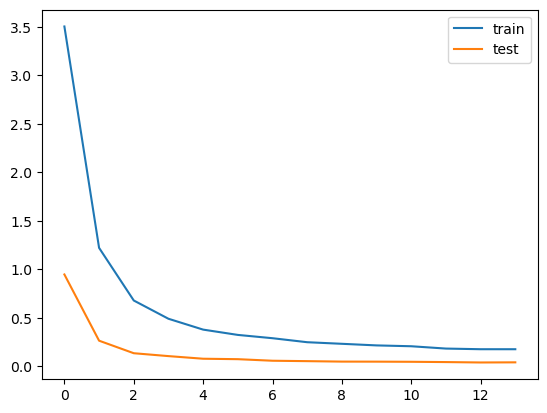

In [15]:
plt.style.use('default')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Section 4: Model Evaluation:

In [16]:
def printPrediction(X_data, y_data, printDigit):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = str(model.predict_classes(X_data[i:i+1])[0])
        speaker = str(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    Y_prob = model.predict_proba(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))
    auc = roc_auc_score(Y_pred, Y_prob, multi_class = 'ovr')
    print('AUC score: %.10f' % auc)



In [18]:
print('\n# TEST DATA #\n')

# score = model.evaluate(X_test, y_test)

# score = model.evaluate(X_test_ros, y_test_ros)

score = model.evaluate(X_test_rus, y_test_rus)

print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
y_temp = list(y_test['speaker_ID'])#.reset_index()
printPrediction(X_test[0:10], y_temp[0:10], False)


# TEST DATA #

89/89 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9848
accuracy: 98.48%

# Generate predictions
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
y=87        - prediction=87        - match=True
y=74        - prediction=74        - match=True
y=87        - prediction=87        - match=True
y=62        - prediction=62        - match=True
y=73        - prediction=73        - match=True
y=107       - prediction=107       - match=True
y=105       - prediction=105       - match=True
y=28        - prediction=28        - match=True
y=73        - prediction=73        - match=True
y=33        - prediction=33        - match=True


Classification Report for Test Data

[[35  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0 59 ...  0  0  0]
 ...
 [ 0  0  0 ... 45  0  0]
 [ 0  0  0 ...  0 62  0]
 [ 0  0  0 ...  0  0 44]]


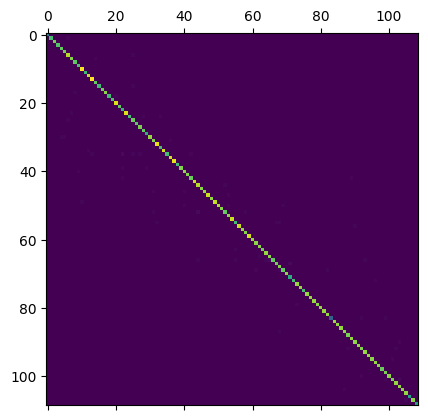


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.98      0.99        54
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        55
           4       0.97      1.00      0.98        57
           5       0.98      0.98      0.98        60
           6       0.97      0.99      0.98        68
           7       0.98      0.98      0.98        62
           8       0.98      1.00      0.99        56
           9       0.98      1.00      0.99        54
          10       0.99      1.00      0.99        74
          11       1.00      1.00      1.00        51
          12       0.99      1.00      0.99        68
          13       0.99      1.00      0.99        75
          14       0.98      1.00      0.99        57
          15       1.00      0.98      0.99        53
          16       1.00      1.00      1.00        59
    

In [408]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

### Section 5: Results Discusion: Please check the report

### Rough work

In [ ]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1, scoring="accuracy").fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())